In [1]:
# Data Management
import numpy as np
import xarray as xr
import pandas as pd
import netCDF4 as nc
import cftime

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy
from cartopy import config
import cartopy.crs as ccrs

# Statistics
import climlab
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_regression
from sklearn.metrics import r2_score
from scipy.linalg import lstsq
from scipy.optimize import fmin_tnc
import scipy.stats as st
import statsmodels.api as sm
from eofs.standard import Eof

# Window Display
import warnings
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
warnings.filterwarnings('ignore')
%matplotlib inline

/data/keeling/a/tjhanke2/miniconda3/lib/python3.8/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


Principal Component Analysis (PCA) is an unsupervised data reduction technique that is designed to reduce an mxn matrix into a kxn matrix, where hopefully k << m. This technique makes it possible to reduce large data arrays into a small amount of principal components (PCs) that explain the most amount of variance as possible in the data array.

PCA does this by utilizing singular value decomposition (SVD), which is a generalization of the eigendecomposition of a square matrix to any mxn matrix. It's used heavily in factor analysis, and has seen a lot of applications in the field of atmospheric science (although, AtmoSci uses the term "Empirical Orthogonal Function Analysis"). Let's go through the mathematics of PCA.

The first assumption that is made in PCA is that the data is centered and has unit variance. For any matrix X, SVD is the factorization of the expression

$$X = U\Sigma V^T$$

Where $\Sigma$ is a diagonal matrix of singular values $\sigma$ in X (so that X can be an mxn matrix, whereas eigenvalues are only for nxn matrices) and U and V are orthogonal matrices. If we want to maximize the amount of variance our singular values (PCs) explain within the data set X, we need to construct the covariance matrix and factorize it. We can calculate the covariance matrix of X by

$$\frac{1}{n-1}X^TX = \frac{1}{n-1}(U\Sigma V^T)^T(U\Sigma V^T)$$
$$\frac{1}{n-1}X^TX = \frac{1}{n-1}(V\Sigma U^T)(U\Sigma V^T)$$
$$\frac{1}{n-1}X^TX = \frac{1}{n-1}V\Sigma U^TU\Sigma V^T$$

Since U is orthogonal, $U^TU = I$. Thus,

$$\frac{1}{n-1}X^TX = \frac{1}{n-1}V\Sigma\Sigma V^T$$
$$\frac{1}{n-1}X^TX = \frac{1}{n-1}V(\Sigma)^2 V^T$$

We now perform eigendecomposition, which is factoring a matrix into seperate eigenvectors. A vector is an eigenvector of a matrix if it solves the matrix equation

$$Av = \lambda v$$

Therefore, the eigendecomposition of the covariance matrix (since the covariance matrix is square) is

$$(\frac{1}{n-1}X^TX)V = \lambda V$$
$$(\frac{1}{n-1}V(\Sigma)^2V^T)V = \lambda V$$
$$\frac{1}{n-1}(\Sigma)^2V = \lambda V$$

So, this shows that the singular values are equal to the eigenvalues of the covariance matrix. Put in other words,

$$\lambda_i = \frac{\sigma^2_i}{n-1}$$

Finally, we can retrieve the principal components by calculating the singular values using the eigenvalues of the covariance matrix and doing

$$XV = (U\Sigma V^T)V = U\Sigma V^TV = U\Sigma$$

Now that we've gone through the mathematics, let's actually decompose a Gaussian dataset.

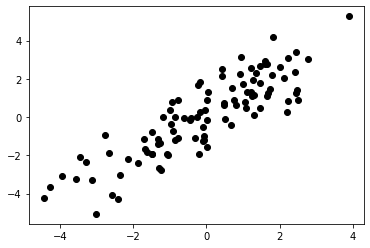

In [96]:
## Create Gaussian Dataset
rng = np.random.RandomState(0)
n_samples = 100
cov = [[3, 3],
       [3, 4]]
X = rng.multivariate_normal(mean=[0, 0], cov=cov, size=n_samples)

plt.scatter(X[:,0], X[:,1], color='k')

In [111]:
## Scale the data
X_scaled = (X - np.mean(X)) / np.std(X)

## Get the covariance matrix of X
cov_X = 1/(n_samples-1)*np.dot(X_scaled,X_scaled.T)

## Perform eigendecomposition on Cov_X
evals,evecs = np.linalg.eigh(cov_X)

## Sort the eigenvalues according to size
sort = evals.argsort()[::-1]
evals,evecs = evals[sort],evecs[:,sort]

## Project the data onto the evecs
pcs = np.matmul(X.T,evecs)

In [135]:
df = pd.DataFrame(np.hstack((pcs.T,X)))
df

,0,1,2,3
0,16.756709,20.060419,-3.123062,-3.267402
1,-5.334788,4.446271,-2.775958,-0.929101
2,-0.001613,-0.001613,-2.582416,-4.072345
3,0.004279,0.004279,-1.492453,-1.920361
4,0.005771,0.005771,-0.041529,0.381166
...,...,...,...,...
95,0.000980,0.000980,1.999328,2.639920
96,-0.003772,-0.003772,0.668528,-0.434654
97,0.002275,0.002275,-0.776426,-1.096271
98,0.003141,0.003141,-1.701433,-1.145681


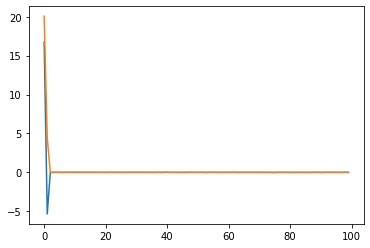

In [144]:
plt.plot(df[0]);
plt.plot(df[1])